## Directional response of the Lightlogger


### 1. Data preparation
----------

#### Jeti data

In [85]:
import pandas as pd
import csv

# File paths
input_file = r'directional_500nm.csv'
filtered_file = r'directional_550nm_filtered.csv'
output_file = r'direc_550nm.csv'

# ________________________ 1. Deleting unnecessary rows ______________________

rows_to_keep = list(range(564, 966))  # Select rows: row 565-966 (index 564-965 in 0-based index)

with open(input_file, 'r', newline='', encoding='ISO-8859-1') as infile, \
     open(filtered_file, 'w', newline='', encoding='ISO-8859-1') as outfile:
    
    reader = csv.reader(infile, delimiter=';')
    writer = csv.writer(outfile, delimiter=';')
    
    for idx, row in enumerate(reader):
        if idx in rows_to_keep:
            writer.writerow(row)

print(f"Filtered data saved to {filtered_file}")

# _______________________ 2. Adding headers to the filtered data __________________

dir_headerlist = [
    'wavelength', 'angle_0', 'angle_-15', 'angle_-30', 'angle_-45', 'angle_-60', 'angle_-75', 'angle_15', 'angle_30', 'angle_45', 'angle_60', 'angle_75',
    '0_2', '-15_2', '-30_2', '-45_2', '-60_2', '-75_2', '15_2', '30_2', '45_2', '60_2', '75_2'
]

# Read the filtered CSV file with header list
dir_df = pd.read_csv(filtered_file, sep=';', names=dir_headerlist, header=None, skiprows=1)

# _________________________ 3. Removing specified columns ___________________________

columns_to_drop = ['0_2', '-15_2', '-30_2', '-45_2', '-60_2', '-75_2', '15_2', '30_2', '45_2', '60_2', '75_2']
dir_df = dir_df.drop(columns=columns_to_drop)

# Strip leading and trailing spaces from all columns
dir_df = dir_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# __________________________ 4. Replace commas with periods in numeric columns __________________________

# Replace commas with periods in all string columns
for column in dir_df.columns:
    if dir_df[column].dtype == object:  # Check if the column is of type string
        dir_df[column] = dir_df[column].str.replace(',', '.', regex=False)

# Convert columns to numeric if possible (optional, if you need them to be numeric types)
dir_df = dir_df.apply(pd.to_numeric, errors='ignore')

# Save the DataFrame with headers to a new CSV file, using ';' as separator
dir_df.to_csv(output_file, index=False, sep=';', quoting=csv.QUOTE_MINIMAL, quotechar='"')

print(f"DataFrame saved to {output_file}")


Filtered data saved to C:\Users\bkaya\Desktop\MPI\Thesis\Field trials\directional\directional_jeti\directional_500nm_filtered.csv
DataFrame saved to C:\Users\bkaya\Desktop\MPI\Thesis\Field trials\directional\directional_jeti\direc_500nm.csv


### 2. Normalization
-----------

In [86]:
# -------------- jeti data ------------------

import pandas as pd

# File path for the input data file
input_file = r'direc_550nm.csv'
# File path for the output normalized data file
output_file = 'normalized_direc_550nm.csv'

# Read the input CSV file into a pandas DataFrame, using ';' as a delimiter
df = pd.read_csv(input_file, delimiter=';')

# Extract the column corresponding to the 0° angle for normalization
angle_0 = df['angle_0']

# Copy the original data to create a new DataFrame for normalization
normalized_df = df.copy()

# Normalize all other angle columns relative to the 0° angle column
for angle in ['angle_-15', 'angle_-30', 'angle_-45', 'angle_-60', 'angle_-75', 
               'angle_15', 'angle_30', 'angle_45', 'angle_60', 'angle_75']:
    normalized_df[angle] = df[angle] / angle_0  # Perform normalization for each angle

# Replace any NaN values with 0 (in case there are divisions by zero from angle_0)
normalized_df.fillna(0, inplace=True)

# Save the normalized data to a new CSV file, using ';' as a delimiter
normalized_df.to_csv(output_file, index=False, sep=';')

# Print a success message with the path to the output file
print(f'Normalized data has been saved to {output_file}')

Normalized data has been saved to normalized_direc_500nm.csv


In [3]:
# -------------- sensor data ------------------

import pandas as pd

# Function to adjust the gain values based on specific cases
def adjust_gain(gain):
    if gain == 0:
        return 1  # Default gain when it's 0
    elif gain == 1:
        return 3.7  # Adjusted gain for value 1
    elif gain == 2:
        return 16  # Adjusted gain for value 2
    elif gain == 3:
        return 64  # Adjusted gain for value 3
    else:
        return gain  # Return the gain as is for other cases

# Function to adjust the integration time based on the formula
def adjust_integration_time(time):
    return (time + 1) * 2.78  # Adjusting the integration time by adding 1 and multiplying by 2.78

# File path for the input sensor data CSV
input_file = r'direc_sensor_500nm.csv'
# File path for the output normalized CSV file
output_file = r'normalized_sensor_500nm.csv'

# Read the input CSV file into a pandas DataFrame, using ';' as a delimiter
df = pd.read_csv(input_file, delimiter=';')

# Extract all channel columns that start with 'c_CH'
channels = [col for col in df.columns if col.startswith('c_CH')]

# Iterate through each row of the DataFrame
for index, row in df.iterrows():
    for channel in channels:
        # Adjust channel responses based on gain and integration time for VIS channels
        if channel.startswith('c_CH'):
            adjusted_gain = adjust_gain(row['VISgain'])
            adjusted_integration_time = adjust_integration_time(row['VISintegrationtime'])
            # Update the channel value by normalizing it with adjusted gain and integration time
            df.at[index, channel] = row[channel] / (adjusted_gain * adjusted_integration_time)
        else:  # For UVA, UVB, and UVC channels
            gain = row['gain']
            integration_time = row['integrationtime']
            # Update the channel value by normalizing it with gain and integration time
            df.at[index, channel] = row[channel] / (gain * integration_time)

# Normalize the data relative to the angle of 0 degrees
df_0 = df[df['angle'] == 0].iloc[0]  # Select the row where the angle is 0°

# Create a new DataFrame to store the normalized data
normalized_df = df.copy()

# Normalize each channel's values by dividing by the corresponding value at 0° angle
for channel in channels + ['UVA', 'UVB', 'UVC']:
    normalized_df[channel] = df[channel] / df_0[channel]

# Replace any NaN values with 0 (in case there are divisions by zero)
normalized_df.fillna(0, inplace=True)

# Save the normalized data to a new CSV file, with ';' as a delimiter
normalized_df.to_csv(output_file, index=False, sep=';')

# Print a success message with the path to the output file
print(f'Normalized data has been saved to {output_file}')


Normalized data has been saved to normalized_sensor_500nm.csv


### 3. Plotting
---------

Sensor response

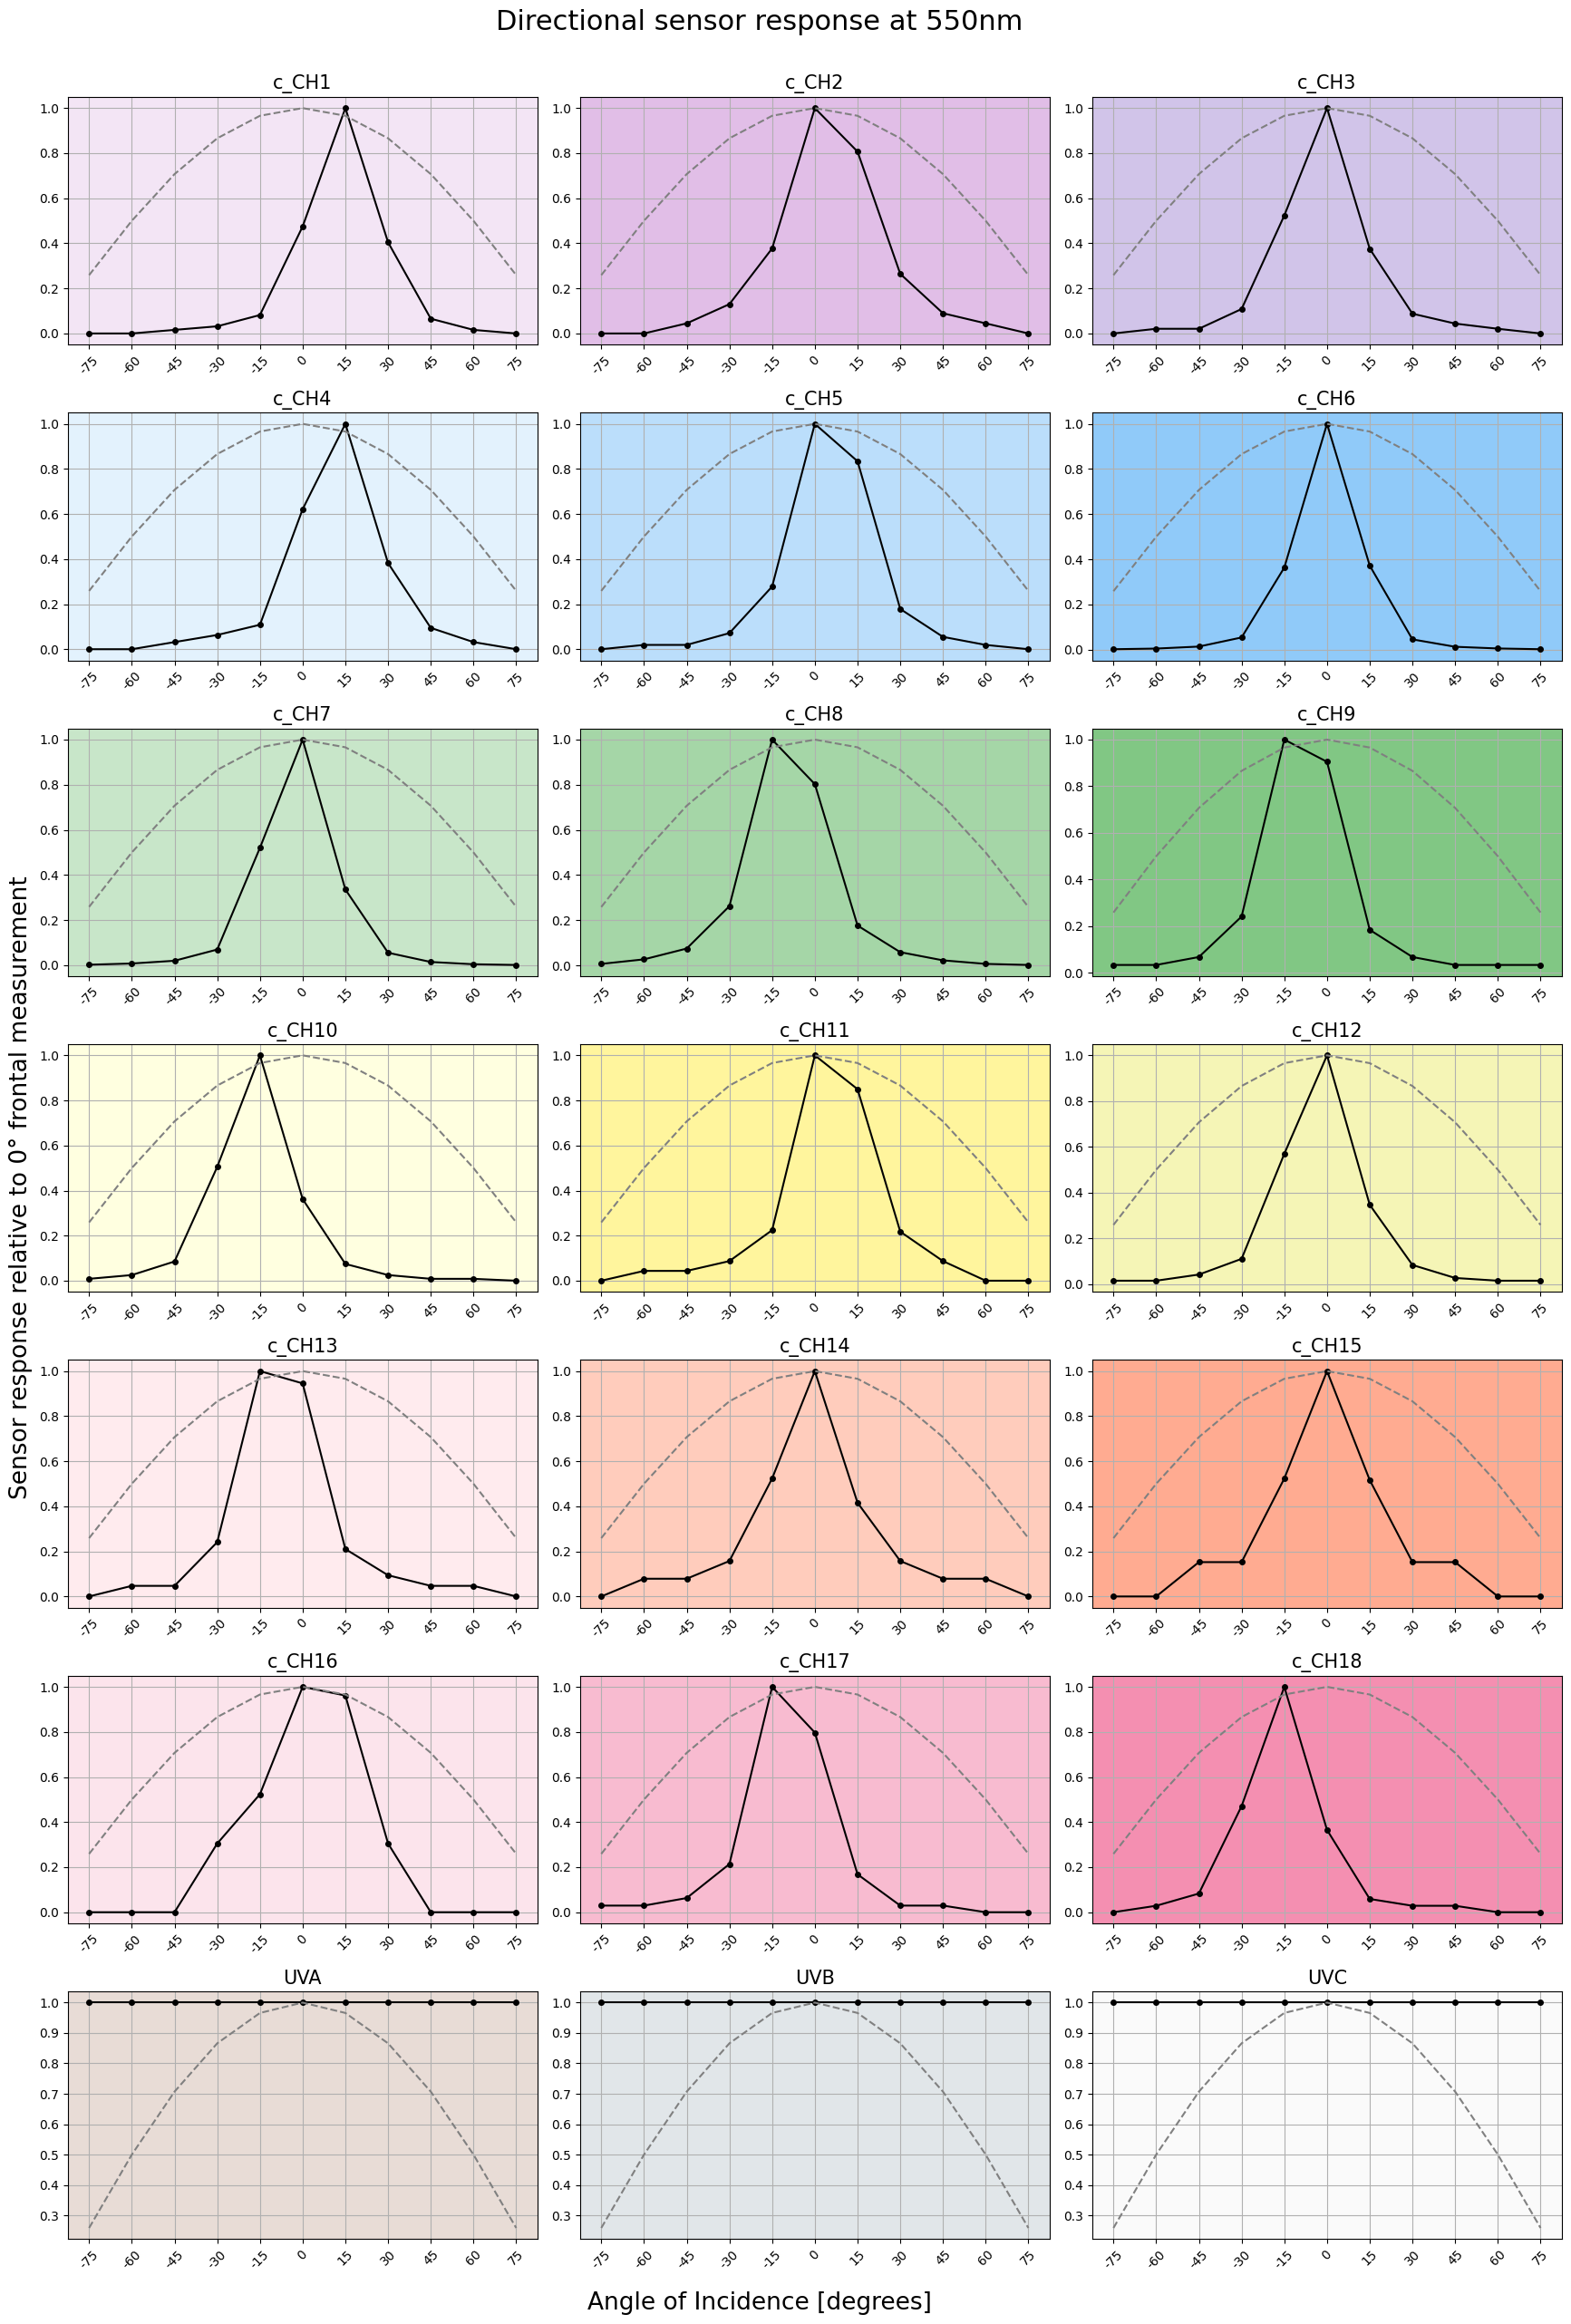

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# File path to the normalized data
input_file = 'normalized_sensor_550nm.csv'

# Read the data into a DataFrame
df = pd.read_csv(input_file, delimiter=';')

# Extract angles and channels from the DataFrame
angles = [-75, -60, -45, -30, -15, 0, 15, 30, 45, 60, 75]  # Predefined angles
channels = [col for col in df.columns if col.startswith('c_CH')] + ['UVA', 'UVB', 'UVC']  # Channel columns

# Sort the DataFrame based on the angle values
df = df.set_index('angle').loc[angles].reset_index()

# Number of channels to plot
num_channels = len(channels)

# Define background colors for the plots, corresponding to each channel
channel_colors = {
    'c_CH1': '#f3e5f5',  # Very light purple
    'c_CH2': '#e1bee7',  # Light purple
    'c_CH3': '#d1c4e9',  # Slightly darker purple
    'c_CH4': '#e3f2fd',  # Very light blue
    'c_CH5': '#bbdefb',  # Light blue
    'c_CH6': '#90caf9',  # Slightly darker blue
    'c_CH7': '#c8e6c9',  # Very light green
    'c_CH8': '#a5d6a7',  # Light green
    'c_CH9': '#81c784',  # Slightly darker green
    'c_CH10': '#ffffe0', # Very light yellow
    'c_CH11': '#fff59d', # Light yellow
    'c_CH12': '#f5f5b6', # Slightly darker yellow
    'c_CH13': '#ffebee', # Very light orange
    'c_CH14': '#ffccbc', # Light orange
    'c_CH15': '#ffab91', # Slightly darker orange
    'c_CH16': '#fce4ec', # Very light red
    'c_CH17': '#f8bbd0', # Light red
    'c_CH18': '#f48fb1', # Slightly darker red
    'UVA': '#e8dcd6',    # Very light beige
    'UVB': '#e1e6e9',    # Light grey
    'UVC': '#fafafa'     # Very light grey-blue
}

# Create a grid of subplots (3 columns, several rows)
cols = 3
rows = (num_channels + cols - 1) // cols  # Calculate rows based on the number of channels
fig, axs = plt.subplots(rows, cols, figsize=(18, 27))  # Define figure size
axs = axs.flatten()  # Flatten the axes for easy indexing

# Create a plot for each channel
for i, channel in enumerate(channels):
    color = channel_colors[channel]  # Get the color for each channel
    
    # Normalize the y-values (sensor response) for the plot
    normalized_response = df[channel] / df[channel].max()
    
    # Plot the normalized response with angle on x-axis
    axs[i].plot(df['angle'], normalized_response, marker='o', markersize=4, linestyle='-', color='black')
    
    # Add cosine function for comparison
    cos_values = np.cos(np.radians(df['angle']))
    axs[i].plot(df['angle'], cos_values, linestyle='--', color='grey')
    
    # Set plot title, grid, and x-axis properties
    axs[i].set_title(f'{channel}', fontsize=15)
    axs[i].grid(True)
    axs[i].set_xticks(angles)
    axs[i].set_xticklabels(angles, rotation=45)
    axs[i].set_facecolor(color)  # Set background color for each subplot

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Add overall title and axis labels to the entire figure
fig.suptitle('Directional sensor response at 550nm', fontsize=22)
fig.text(0.5, 0.04, 'Angle of Incidence [degrees]', ha='center', fontsize=19)
fig.text(0.04, 0.5, 'Sensor response relative to 0° frontal measurement ', va='center', rotation='vertical', fontsize=19)

# Adjust the layout and display the plots
plt.tight_layout(rect=[0.05, 0.05, 1, 0.975])
plt.show()